# Basic Usage
In this tutorial you will learn the basic usage of EncoderMap with a little toy data set. 

### Import Libraries
Before we can get started using EncoderMap we first need to import the EncoderMap library:

In [1]:
import encodermap as em

We will also need some aditional imports for plotting:

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### Load Data
Next, we need to load our data. EncoderMap expects the input data to be a 2d array. Each line should contain one data point and the number of columns is the dimensionality of the data set. Here, you could load data from any source. In this tutorial, however, we will use a function to generate a toy data set. The function `random_on_cube_edges` distributes a given number of points randomly on the edges of a cube. We can also add some Gaussian noise by specifying a sigma value.

In [9]:
high_d_data, ids = em.misc.random_on_cube_edges(5000, sigma=0.05)

let's look at the data we have just created:

In [8]:
print("high_d_data\n", high_d_data)
print("ids\n", ids)

high_d_data
 [[ 1.01653194 -0.08968255  0.27286496]
 [ 0.98662361  0.89952559  0.99609753]
 [-0.07694052  1.05808532  0.3591041 ]
 ...
 [ 0.26406349  0.03557675  1.00505435]
 [ 1.03199014 -0.03820525  1.03282977]
 [ 0.637986   -0.01178829 -0.04576743]]
ids
 [11.  5.  8. ...  9. 11.  0.]


`high_d_data` is a 2d array where each row represents one point in a 3d space. `ids` contains a number form 0 to 11 for each point. This number tells us which edge of the cube each point belongs to. We can use these `ids` to color the points in a plot. The following code creates a scatter plot of the data: 

<IPython.core.display.Javascript object>


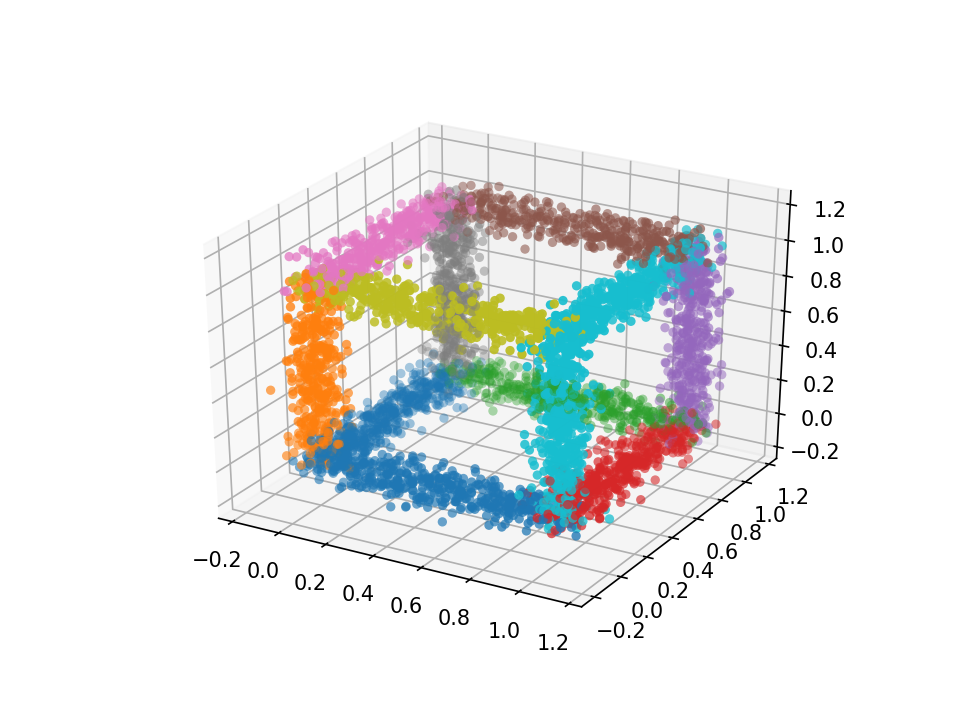

In [17]:
fig = plt.figure()
axe = fig.add_subplot(111, projection='3d')
axe.scatter(high_d_data[:, 0], high_d_data[:, 1], high_d_data[:, 2], 
            c=ids, marker="o", linewidths=0, cmap="tab10")

### Select Parameters
Now  that we have loaded our data we need to select parameters for EncoderMap. Parameters are stored in an object derived from the `Parameters` class. A list of the available parameters can be found [here](https://ag-peter.github.io/encodermap/docbuild/html/parameters.html#module-encodermap.parameters). We do not need to bother with all these parameters, as the default parameters should be fine in many cases. We should, however adjust some parameters for this example:

In [18]:
parameters = em.Parameters()
parameters.main_path = em.misc.run_path("runs/cube")
parameters.periodicity = float("inf")
parameters.n_steps = 10000

The `main_path` defines where output files will be written. `run_path` is a helper function which creates a new numbered run directory. When you call this for the first time it will create a directory `runs/cube/run0`. If this directory already exist it will instead create the directory `runs/cube/run1` and so forth.

The `periodicity` is important for periodic input such as angular values. As the input in this case in not periodic we set the periodicity to infinite.

`n_steps` defines the number of training iterations.

Furthermore, we should adjust the sigmoid functions applied to the high-dimensional and low-dimensional pairwise distances of the distance based part of the cost function. There a three parameters for each sigmoid which should be given in the following order:  
(sig_h, a_h, b_h, sig_l, a_l, b_l)  
In order to select these parameters it is helpful to plot the high-d sigmoid function together with a histogram of the pairwise distances in the data set. 

<IPython.core.display.Javascript object>


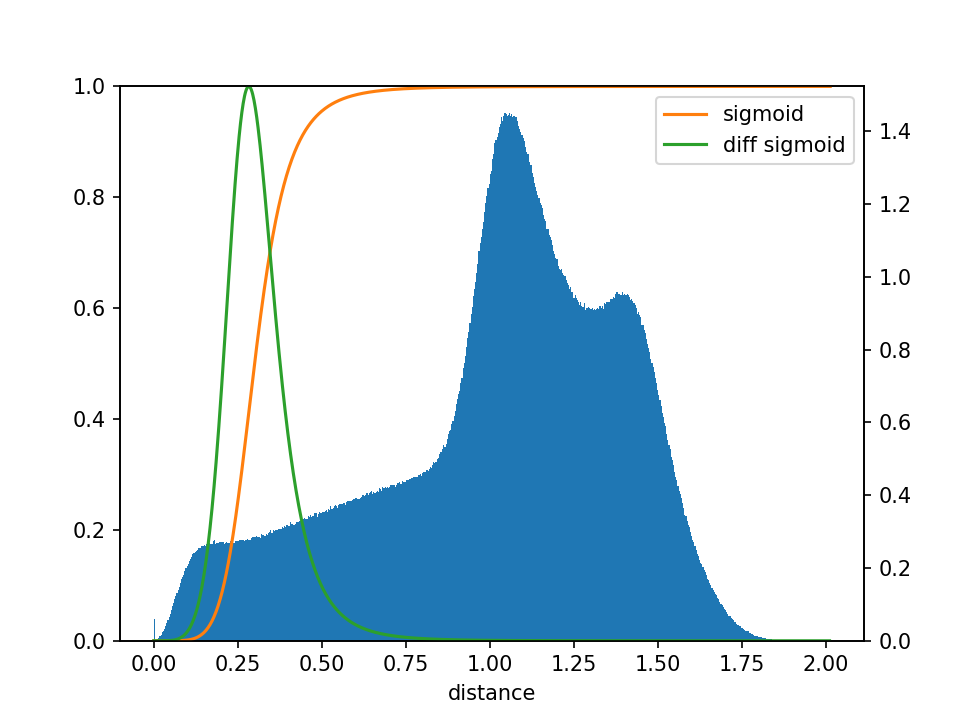

In [27]:
parameters.dist_sig_parameters = (0.3, 6, 6, 1, 4, 6)
em.plot.distance_histogram(high_d_data, 
                           parameters.periodicity, 
                           parameters.dist_sig_parameters[0:3])

Beside the sigmoid function and the pairwise distances histogram, the plot also shows the derivative of the sigmoid function. This derivative shows the sensitive range of the distance based part of the cost function. As it is not possible to preserve all pairwise distances in the low-d representation we want to tune this sensitive range to match distances which are most important for us. Usually very short distances are not important for the structure of a data set as these distances stem from points inside the same local region. Long distances might be interesting but can hardly be reproduced in a lower dimensional representation. Somewhere in between are the most important distances which contain the information how local regions in the data are connected to neighboring regions.

The sigmoid parameters for the low-d space can be selected according to the following rules:  
`sig_l` = 1  (is irrelevant as it only scales the low-dimensional map)  
`a_l` = a_h * n_dimensions_l / n_dimensions_h  
`b_l`= b_h  
Further information about the the selection of these sigmoid parameters can be found in the [Sketchmap literature](http://sketchmap.org). 

Feel free to play with different sigmoid parameters and see how the sigmoid function changes in the previous cell. I recommend to continue the tutorial with (0.3, 6, 6, 1, 4, 6) for a start but you can come back later and changes these parameters.

### Performe Dimensionality Reduction

Now that we have set up the parameters and loaded the data, it is very simple to performe the dimensionality reduction. All we need to do is to create an EncoderMap object and call its `train` method. The EncoderMap object takes care of setting up the neural network autoencoder and once you call the `train` method this network is trained to minimize the cost function as specified in the parameters.

In [ ]:
e_map = em.EncoderMap(parameters, high_d_data)
e_map.train()

Once the network is trained we can feed high dimensional data into the encoder part of the network and read the values from the bottleneck layer. That is how we project data to the low dimensional space. The following line projects all our high-dimensional data to the low-dimensional space:

In [33]:
low_d_projection = e_map.encode(high_d_data)

Let's have a look at the result and plot the data:

<IPython.core.display.Javascript object>


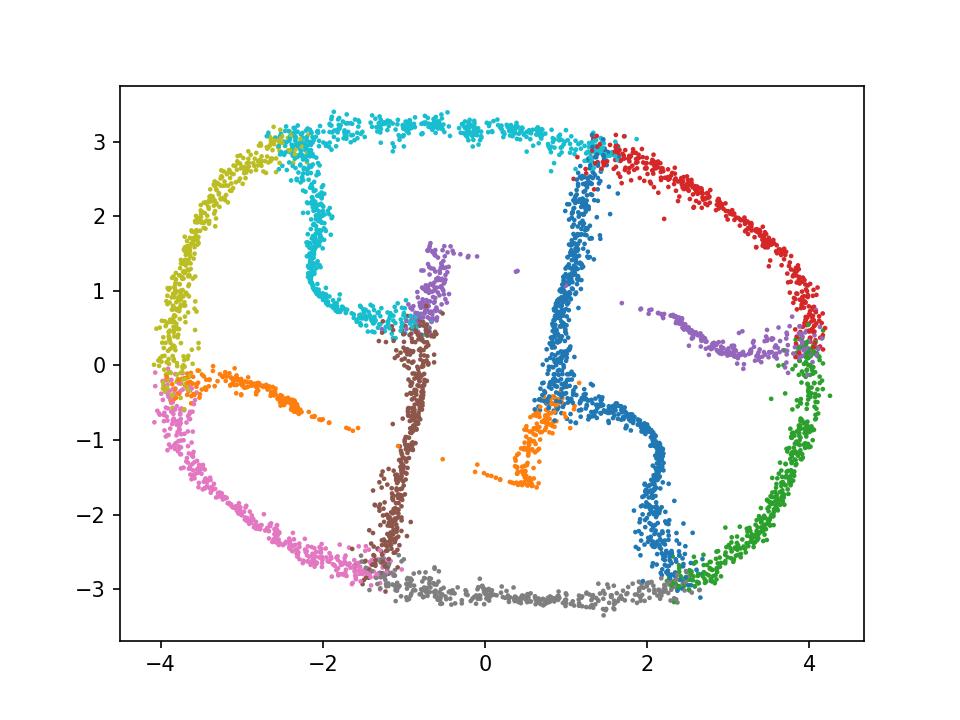

In [34]:
fig, axe = plt.subplots()
axe.scatter(low_d_projection[:, 0], low_d_projection[:, 1], c=ids, s=5, marker="o", linewidths=0, cmap="tab10")

### Generate High-Dimensional Data

We can not only use the encoder part the network to project points the to the low-dimensional space. Also, the inverse procedure is possible using the decoder part of the Network. This allows to project any point from the low-dimensional space to the high dimensional space.  
In the following we feed all low-dimension points into the decoder part of the network to generate high dimensional points:

In [35]:
generated = e_map.generate(low_d_projection)

Let's have a look at these generated point:

<IPython.core.display.Javascript object>


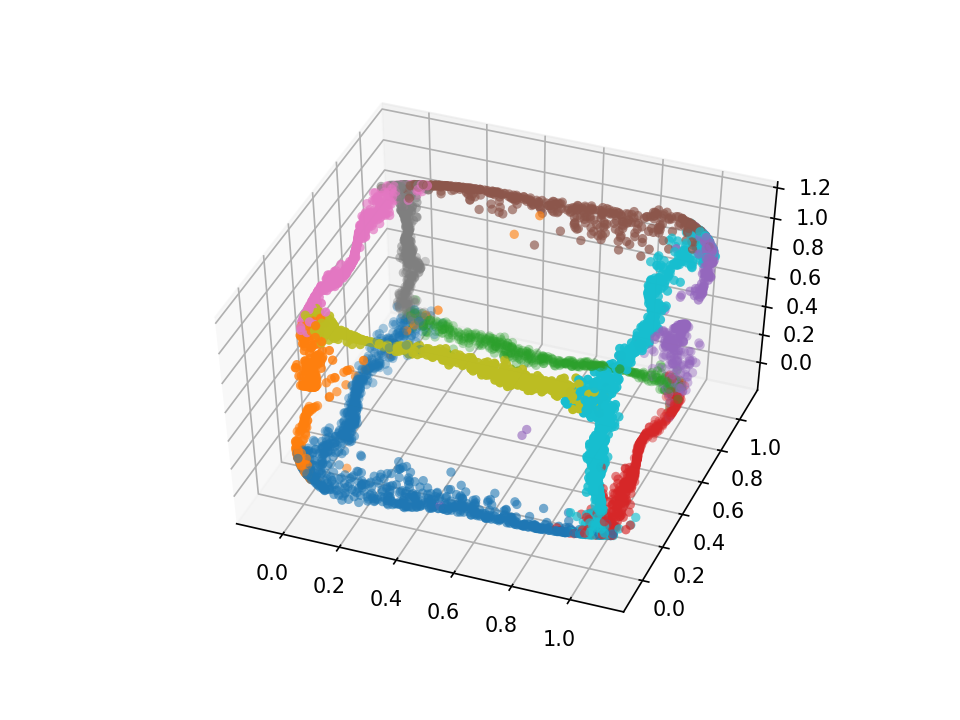

In [36]:
fig = plt.figure()
axe = fig.add_subplot(111, projection='3d')
axe.scatter(generated[:, 0], generated[:, 1], generated[:, 2], c=ids, marker="o", linewidths=0, cmap="tab10")

You probable see again a cube like structure. The reconstruction, however, will not be perfect, as information is lost when the data is projected to a lower dimensional space.

### Conclusion

In this tutorial you have learned how to set parameters, run the dimensionality reduction and how to project points from the high-dimensional space to the low dimensional space and vice versa.